In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import json
from keras.models import load_model
import pandas as pd
from scipy.stats import pearsonr
from keras.utils.generic_utils import get_custom_objects
from losses import neg_log_likelihood
from util import partition_data, get_balaji_predictions, get_experimental_X_y, get_gfp_X_y_aa
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams["font.family"] = "serif"
cm = plt.get_cmap('viridis_r')
plt.style.use('seaborn-paper')


Using TensorFlow backend.


In [2]:

ALL_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
METHODS = [
    'kl_den_log_sf_fitness_315_sim_095_p_margin_1_decoder_eps_00001_fitness_weight_005',
    'kl_den_log_sf_fitness_315_sim_05_p_margin_1000_decoder_eps_00001_fitness_weight_005',
    'cbas',
    'fbvae',
    'cem-pi'
]
METHOD_COLORS = {METHODS[i]: ALL_COLORS[i] for i in range(len(METHODS))}
METHOD_COLORS['killoran'] = ALL_COLORS[len(METHODS)]


In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [4]:
def plot_traj(quantile=0.8, traj_it=1, sort=True, mean=False, use_from=0, use_first=50, y_max=6.0, sub=True, methods_to_use=None, figsize=(8, 6)):
    for i in [traj_it]:
        for j in range(1):
            fig = plt.figure(figsize=figsize)
            suffix = '_5k_%i_%i_w_edit_distances' %(i, j)
            if use_first > 100:
                suffix += "_long"
            methods = methods_to_use if methods_to_use is not None else None
            if methods_to_use is None :
                if sub:
                    methods = [ 'cbas', 'fbvae']
                else:
                    methods = [ 'cbas', 'fbvae', 'rwr', 'dbas', 'cem-pi']
            for k in range(len(methods)):
                method = methods[k]
                oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[use_from:use_first]
                gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[use_from:use_first]
                
                if mean:
                    oracle_vals= np.mean(oracle_samples, axis=1)
                    gt_vals = np.mean(gt_samples, axis=1)
                else:
                    per = np.percentile(oracle_samples, quantile*100, axis=-1)
                    per = per.reshape(oracle_samples.shape[0], 1)
                    oracle_idxs = np.where(oracle_samples > per)
                    
                    oracle_vals = np.zeros_like(oracle_samples)
                    oracle_vals[oracle_idxs] = oracle_samples[oracle_idxs]
                    oracle_vals = np.true_divide(oracle_vals.sum(1),(oracle_vals!=0).sum(1))
                    
                    gt_vals = np.zeros_like(gt_samples)
                    gt_vals[oracle_idxs] = gt_samples[oracle_idxs]
                    gt_vals = np.true_divide(gt_vals.sum(1),(gt_vals!=0).sum(1))
                
                x = range(oracle_samples.shape[0])
                if sort:
                    sorted_idx = np.argsort(oracle_vals)
                else:
                    sorted_idx = range(len(x))
                    
                lbl = method.upper()
                if method == 'cbas':
                    lbl = 'CbAS'
                elif method == 'dbas':
                    lbl = 'DbAS'
                    
                print(method, np.max(gt_vals[~np.isnan(gt_vals)]))
                plt.plot(x, gt_vals[sorted_idx], c=METHOD_COLORS[method], label="%s" % lbl, zorder=len(methods)-j)
                plt.plot(x, oracle_vals[sorted_idx], c=METHOD_COLORS[method], ls='--', zorder=len(methods)-j)

            plt.xlim(0, use_first)
            plt.ylim(2.8, y_max)
            
            plt.ylabel("$%i^{th}$ percentile of $y$ samples" % int(quantile*100))
            plt.xlabel("Iteration (sorted by oracle values)")
            plt.legend(frameon=True, loc='lower left')
            plt.grid(True)
            plt.gca().set_axisbelow(True)
            plt.gca().grid(color='gray', alpha=0.2)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')
            if sub:
                plt_name = "plots/traj_%.1f_%i_%i_sub.png" % (quantile, i, j)
            else:
                plt_name = "plots/traj_%.1f_%i_%i_all.png" % (quantile, i, j)
            print(plt_name)
            plt.tight_layout()
            
            plt.savefig("plots/gfp_sf_kl_den_trajs_" + str(use_from) + "_" + str(use_first) + "_traj_" + str(i) + "_" + str(y_max).replace(".", "") + ".png", dpi=150, transparent=True)
            plt.savefig("plots/gfp_sf_kl_den_trajs_" + str(use_from) + "_" + str(use_first) + "_traj_" + str(i) + "_" + str(y_max).replace(".", "") + ".eps")
            plt.savefig("plots/gfp_sf_kl_den_trajs_" + str(use_from) + "_" + str(use_first) + "_traj_" + str(i) + "_" + str(y_max).replace(".", "") + ".svg")

            
            plt.show()

kl_den_log_sf_fitness_315_sim_095_p_margin_1_decoder_eps_00001_fitness_weight_005 3.3570636744974784
kl_den_log_sf_fitness_315_sim_05_p_margin_1000_decoder_eps_00001_fitness_weight_005 2.8939955225762914
cbas 3.3204623196472998
fbvae 3.266563297573355
cem-pi 3.3318376969454144
plots/traj_0.8_2_0_all.png


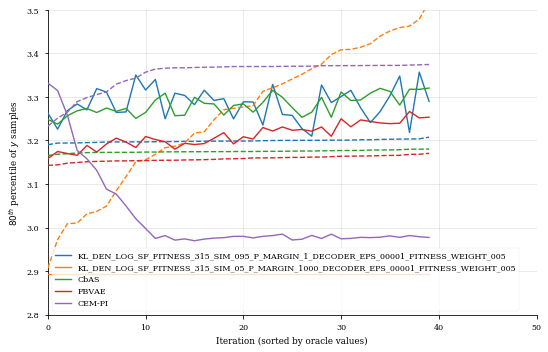

In [5]:
plot_traj(quantile=0.8, traj_it=2, sort=True, mean=False, use_from=10, use_first=50, y_max=3.5, sub=False, methods_to_use=METHODS, figsize=(8,5))